**Importing Required Libraries**

In [14]:
import numpy as np
import pandas as pd
import tensorflow as tf
tf.random.set_seed(42)
import matplotlib.pyplot as plt
from glob import glob
import cv2
import os
import shutil
import random
import math
import tensorflow_datasets as tfds

In [4]:
""" google drive """
from google.colab import drive
drive.mount('/content/drive')

"directory pahts"
directory_path = '/content/drive/MyDrive/Drive_Drowsiness_Detection'

Mounted at /content/drive


**Checking TensorFlow Version**

In [ ]:
from tensorflow.python import keras
print(keras.__version__)

2.6.0


**Creating a Folder to Store TFRecords**


In [9]:
!mkdir /content/drive/MyDrive/Drive_Drowsiness_Detection/images

mkdir: cannot create directory ‘/content/drive/MyDrive/Drive_Drowsiness_Detection/images’: File exists


**Function to Convert Arrays to Binary Stream**


In [10]:
def _bytes_feature(value):
    if isinstance(value, type(tf.constant(0))): 
        value = value.numpy() 
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

**Function to Convert A Sample to Binary Stream**


In [11]:
def serialize_example(image,label):
    feature = {
        'image':tf.train.Feature(bytes_list=tf.train.BytesList(value=[image])),
        'label':_bytes_feature(tf.io.serialize_tensor(label))
    }
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    return example.SerializeToString()

**Function to Create TF Records from Binary Stream Objects**

In [18]:
def create_records(path,op_path='/content/drive/MyDrive/Drive_Drowsiness_Detection/images/tensor_records'):
    classes=os.listdir(path)
    with tf.io.TFRecordWriter(op_path) as writer:
        files_list = glob(path+'/*/*')
        random.shuffle(files_list)
        for fn in files_list:
            label = np.array([0,0],dtype='float64')
            img = open(fn,'rb').read()
            lab = fn.split('/')[-2]
            lab = classes.index(lab)
            label[lab] = 1.0
            tf_example = serialize_example(img,label)
            writer.write(tf_example)


Calling all the above Functions

In [23]:
create_records('/content/drive/MyDrive/Drive_Drowsiness_Detection/data/train')

**Below Functions create TF Dataset from TFRecords effeciently**


In [24]:
def parse_image(example):

    feature = {'image':tf.io.FixedLenFeature([],tf.string),
              'label':tf.io.FixedLenFeature([],tf.string)}
    features = tf.io.parse_single_example(example,feature)
    image = tf.io.decode_jpeg(features['image'],channels = 3)
    image = tf.image.resize(image,[256,256])
    label = tf.io.parse_tensor(features['label'], out_type=tf.float64)
    label = tf.reshape(label,shape=(2,))
    return image,label
def read_dataset(filename,batchs):
    data = tf.data.TFRecordDataset(filename)
    img_count = len(glob('/content/drive/MyDrive/Drive_Drowsiness_Detection/data/train' +'/*/*'))
    val_size = int(img_count * 0.2)
    train_ds = data.skip(val_size)
    val_ds = data.take(val_size)
    train_ds = configure(train_ds)
    val_ds =  configure(val_ds)
    return train_ds,val_ds
    
def configure(data):
    data = data.map(parse_image,num_parallel_calls = tf.data.experimental.AUTOTUNE)
    data = data.shuffle(500)
    data = data.batch(32,drop_remainder = True)
    data = data.repeat()
    data = data.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
    return data

**Calling the above functions to Create a full TF dataset**

In [25]:
def use_records():
    train,val = read_dataset("/content/drive/MyDrive/Drive_Drowsiness_Detection/images/tensor_records",32)
    return train,val
train_ds,val_ds = use_records() 

**Checking the shape of a batch in our TF Dataset**

In [26]:
for image, label in val_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy().shape)

Image shape:  (32, 256, 256, 3)
Label:  (32, 2)


**Visualising a Sample**

Label:  [0. 1.]


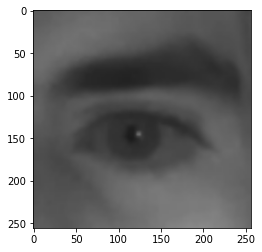

In [27]:
#Label 1 , 0 => Open eye & Label 0 , 1 => Closed eye
for image, label in val_ds.take(1):
  print("Label: ", label.numpy()[0])
  plt.imshow(image.numpy()[0].astype("uint8"))

**Lenght of Training Data and Validation Data**


In [28]:
img_count = len(glob('/content/drive/MyDrive/Drive_Drowsiness_Detection/data/train' +'/*/*'))
val_size = int(img_count * 0.2)
print(img_count-val_size,val_size)

3208 802


**Creating CallBacks to choose the choose the epoch's weight that gives the best score**

In [29]:
cb = [tf.keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Drive_Drowsiness_Detection/first_model.h5",monitor='val_accuracy',save_best_only=True,mode='max')]

**Building CNN Architecture**

In [30]:
def build():
  model = tf.keras.Sequential([
  tf.keras.layers.Resizing(256,256),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.RandomFlip(mode="horizontal"),
  tf.keras.layers.RandomRotation(0.2, fill_mode='reflect',interpolation='bilinear'),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(2,activation='softmax')
 ])
  model.compile(
  optimizer='adam',
  loss=tf.losses.BinaryCrossentropy(),
  metrics=['accuracy'])
  return model  

**Calling CNN Architecture Function**

In [31]:
model = build()

**Training our own scratch-built CNN**

In [32]:
deep_model = model.fit(train_ds,steps_per_epoch=math.ceil(3208/32),validation_data=val_ds,validation_steps = math.ceil(802/32),epochs =10,callbacks=cb)


Epoch 1/10
101/101 [==============================] - 264s 3s/step - loss: 0.3107 - accuracy: 0.8496 - val_loss: 0.1067 - val_accuracy: 0.9603
Epoch 2/10
101/101 [==============================] - 246s 2s/step - loss: 0.1109 - accuracy: 0.9592 - val_loss: 0.1633 - val_accuracy: 0.9435
Epoch 3/10
101/101 [==============================] - 247s 2s/step - loss: 0.1017 - accuracy: 0.9657 - val_loss: 0.0588 - val_accuracy: 0.9796
Epoch 4/10
101/101 [==============================] - 248s 2s/step - loss: 0.0847 - accuracy: 0.9734 - val_loss: 0.0841 - val_accuracy: 0.9688
Epoch 5/10
101/101 [==============================] - 247s 2s/step - loss: 0.0848 - accuracy: 0.9712 - val_loss: 0.0491 - val_accuracy: 0.9808
Epoch 6/10
101/101 [==============================] - 247s 2s/step - loss: 0.1006 - accuracy: 0.9610 - val_loss: 0.0543 - val_accuracy: 0.9808
Epoch 7/10
101/101 [==============================] - 247s 2s/step - loss: 0.0571 - accuracy: 0.9830 - val_loss: 0.0386 - val_accuracy: 0.9904

**Visualsing Our Model's Performance**

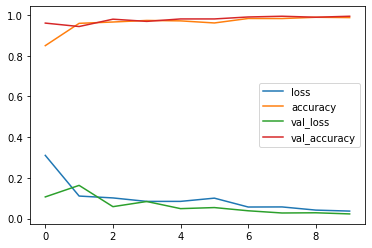

In [33]:
pd.DataFrame(deep_model.history).plot()

**Importing the best model to Test Our Model**

In [34]:
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/Drive_Drowsiness_Detection/first_model.h5")

**Evaluating Our Imported Model**

In [35]:
loaded_model.evaluate(val_ds,steps = math.ceil(802/32))

26/26 [==============================] - 16s 581ms/step - loss: 0.0275 - accuracy: 0.9940


[0.027490386739373207, 0.9939903616905212]

**Summary of our scratch-built CNN**

In [36]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (32, 256, 256, 3)         0         
                                                                 
 rescaling (Rescaling)       (32, 256, 256, 3)         0         
                                                                 
 random_flip (RandomFlip)    (32, 256, 256, 3)         0         
                                                                 
 random_rotation (RandomRota  (32, 256, 256, 3)        0         
 tion)                                                           
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                      